# Project: The Movie Database Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This project performs and presents data analysis of The Movie Database's (TMDB) movie revenue dataset. Data contained in this dataset describe the budget, revenue, user rating, and other properties associated with various movies released since 1960. The analysis addresses the following questions:
1. <a href="#q1">Is the overall profitability of the movie industry increasing or decreasing over time?</a>
2. <a href="#q2">What are the most common keywords?</a>
3. <a href="#q3">How do the revenue distributions for movies containing "Sex", "Sport", and "Murder" compare?</a>
4. <a href="#q4">Is the mean revenue higher with or without each of these keywords?</a>
5. <a href="#q5">Is the mean user score higher with or without each of these keywords?</a>


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# set some color values to create a common color theme for graphs
hex_blue = "#16b5ff"
hex_teal = "#00ffc3"
hex_dgreen = "#00a07a"

# Set the style for all charts
sns.set_style('darkgrid')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

First, let's load the dataset into a Pandas DataFrame. Then, we will review the first three records to understand the dataset's structure.

In [104]:
# Load the dataset from .csv source
df = pd.read_csv('movie_data.csv')

# Print the first 5 lines to understand content
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08



The dataset looks to have several columns that don't relate to the questions at hand. Let's review the column labels to select which are irrelevelant. 


In [105]:
# Loop through column names, printing each one
for col in df.columns:
    print(col)

id
imdb_id
popularity
budget
revenue
original_title
cast
homepage
director
tagline
keywords
overview
runtime
genres
production_companies
release_date
vote_count
vote_average
release_year
budget_adj
revenue_adj


The columns that are unimportant to the present analysis are: __'id', 'imdb_id', 'popularity', 'budget', 'revenue', 'cast', 'homepage', 'director', 'tagline', 'overview', 'runtime', 'genres', 'production_companies', 'release_date', 'vote_count'__. We will remove them in the Data Cleaning section. 

The Columns that we will keep are: __'original_title', 'keywords', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj'__.

We should also consider which columns have records containing NaN (or Nulls), as we will need to clean these up as well.

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

Based on the above, we only need to address Nulls in the __'keywords'__ column because the other columns containing Nulls will be entirely eliminated from the dataset. 

We can use the same information generated by the above `.info()` method to determine if our columns are using appropriate data types. __'release_year'__ is the only column that uses a questionable data type (int64 instead of datetime). For the purpose of this analysis, int64 should suffice, as we will not need any true date functions to answer our questions. 

### Data Cleaning: Handling Nulls and Removing Unnecessary Columns

We need to correct the two problems we identified in our dataset: unnecessary columns and Null values. We will start by removing the unnecessary columns. By doing this first, we ensure otherwise valid records aren't eliminated when we remove Nulls. 

Columns to remove: __'id', 'imdb_id', 'popularity', 'budget', 'revenue', 'cast', 'homepage', 'director', 'tagline', 'overview', 'runtime', 'genres', 'production_companies', 'release_date', 'vote_count'__.

In [107]:
# Store the names of all unnecessary columns in a list
col_to_remove = ['id', 'imdb_id', 'popularity', 
                 'budget', 'revenue', 'cast', 
                 'homepage', 'director', 'tagline', 
                 'overview', 'runtime', 'genres', 
                 'production_companies', 'release_date', 'vote_count']

# Drop the columns from the DataFrame
df.drop(labels=col_to_remove, axis=1, inplace=True)

# Confirm the results of the above drop() statement
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 6 columns):
original_title    10866 non-null object
keywords          9373 non-null object
vote_average      10866 non-null float64
release_year      10866 non-null int64
budget_adj        10866 non-null float64
revenue_adj       10866 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 509.4+ KB


Removing records where __'keywords'__ contains `Null` could impact the analysis performed for questions not related to __'keywords'__. As such, we will store the results of the remove `Null` operation in a second DataFrame and use that DataFrame only when attempting to answer questions pertaining to __'keywords'__.

In [108]:
# Drop all records where at least one field is Null
df_keywords = df.dropna(axis=0)

# Check the contents of the second DataFrame to confirm results
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9373 entries, 0 to 10865
Data columns (total 6 columns):
original_title    9373 non-null object
keywords          9373 non-null object
vote_average      9373 non-null float64
release_year      9373 non-null int64
budget_adj        9373 non-null float64
revenue_adj       9373 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 512.6+ KB


Now, we remove the __'keywords'__ column from the original DataFrame since it is no longer necessary.

In [109]:
# Drop the keywords columns from original DataFrame
df.drop(labels='keywords', axis=1, inplace=True)

# Check the contents of Datafrome to confirm results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 5 columns):
original_title    10866 non-null object
vote_average      10866 non-null float64
release_year      10866 non-null int64
budget_adj        10866 non-null float64
revenue_adj       10866 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 424.5+ KB


<a id='eda'></a>
## Exploratory Data Analysis

<a id='q1'></a>
### Question 1: Is the overall profitability of the movie industry increasing or decreasing over time?

This question requires us to consider a metric not currently present in our dataset: profitability. Let's add a new column to represent this value. We define __'profit'__ as __'revenue_adj'__ less __'budget_adj'__.

In [110]:
# Create a new column by calculating the difference between revenue_adj and budget_adj
df['profit'] = df['revenue_adj'] - df['budget_adj']

# Check the contents of the new column
df.iloc[:3, -3:]

,budget_adj,revenue_adj,profit
0,1.379999e+08,1.392446e+09,1.254446e+09
1,1.379999e+08,3.481613e+08,2.101614e+08
2,1.012000e+08,2.716190e+08,1.704191e+08


We can calculate the overall profit margin for each __'release_year'__ by dividing the sum of __'profit'__ by the sum of __'revenue_adj'__. This will give us a much more readable metric.

In [111]:
# Create a group by object using release_year
gb = df.groupby('release_year')

# Calculate the 'gp_marg' for each release year and store the result in a new DataFrame
df_profit_marg = gb['profit'].sum() / gb['revenue_adj'].sum() * 100

# Clean up the structure of the DataFrame by reseting the index and renaming the derived column from above
df_profit_marg = df_profit_marg.reset_index().rename(index=str, columns={0:'gp_marg'})

# Check the contents of resulting DataFrame
df_profit_marg.head(3)

,release_year,gp_marg
0,1960,84.788836
1,1961,86.338691
2,1962,74.616307


Let's visualize the data using a scatter plot.

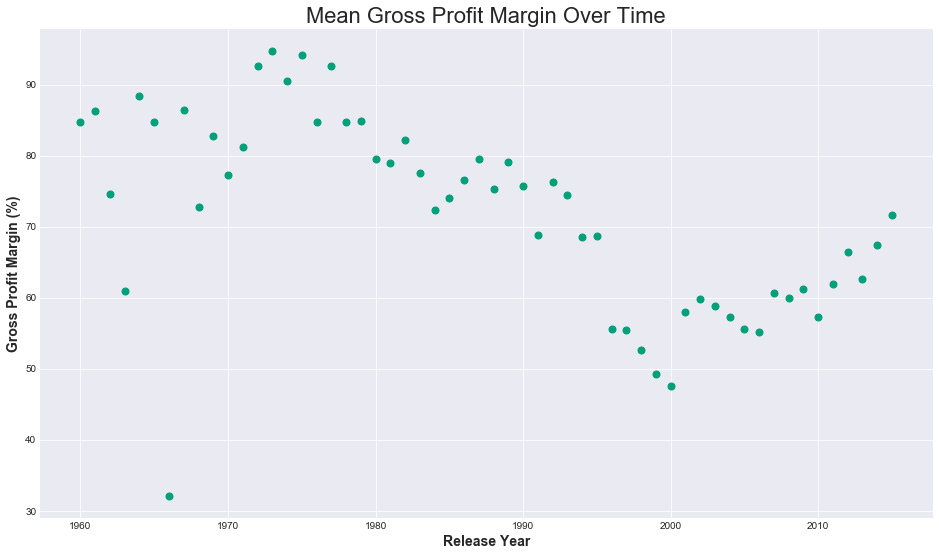

In [112]:

# Create scatter plot while setting figure size and color
df_profit_marg.plot(x='release_year', y='gp_marg', kind='scatter', figsize=(16, 9), color=hex_dgreen, s = 49) 

# Title the plot
plt.title('Mean Gross Profit Margin Over Time', fontsize=22)

# Label the axes and edit font
plt.xlabel('Release Year', fontsize = 14, fontweight='bold')
plt.ylabel('Gross Profit Margin (%)', fontsize = 14, fontweight = 'bold');

<a id='q2'></a>
### Question 2: What are the most common keywords?

This question will require some clever manipulation of the __'keywords'__ column. The __'keywords'__ column contains `|` separated lists of keywords for each movie stored in a string. We will use a list comprehension to flatten the 2D list created by splitting the __'keywords'__ column on `|`.


In [113]:
# List comprehension to flatten the 2D list created by splitting the keywords column
list_of_keywords = [item for sublist in df_keywords['keywords'].str.split('|').tolist() for item in sublist]

# We use np.unique to identify unique keywords in our list. This method will also count the occurence of those keywords
keyword, count = np.unique(list_of_keywords, return_counts=True)

# Create a new DataFrame from the results of np.unique
keyword_counts = pd.DataFrame({'keyword': keyword,
                               'count':   count
                              })

# Use DataFrame.nlargest to drop all but the 10 most common keywords
keyword_counts = keyword_counts.nlargest(10, 'count')

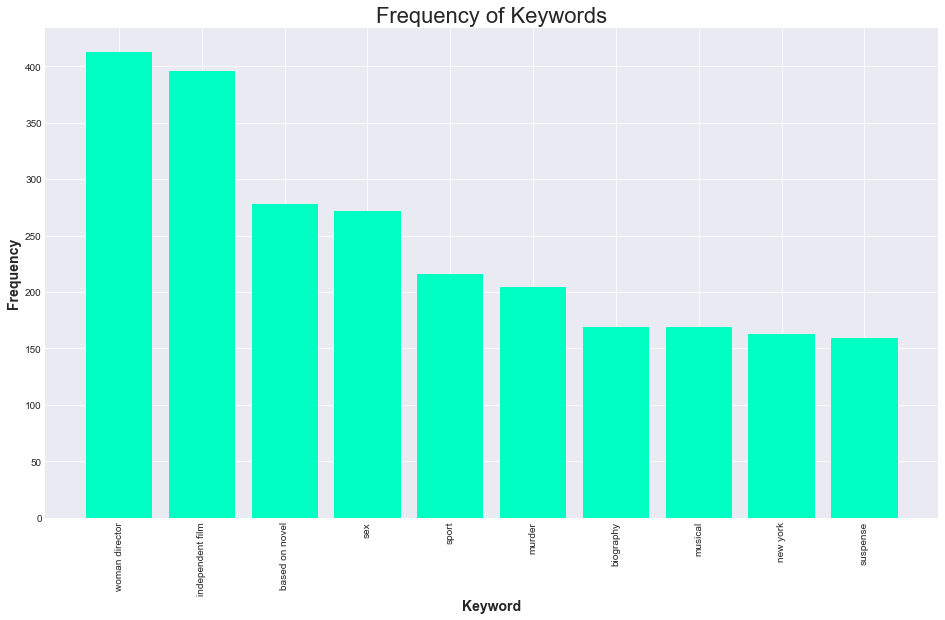

In [114]:
# Visualize the top 10 keywords with barchart
x = np.arange(len(keyword_counts['keyword']))
y = keyword_counts['count']
labels = keyword_counts['keyword']

# Set size of plot
plt.rcParams['figure.figsize'] = (16, 9)

# Create barchart
plt.bar(x, y, color = hex_teal)

# Label the xticks with keyword names and make them vertical
plt.xticks(x, labels, rotation='vertical')

# Label the axes
plt.xlabel('Keyword', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Change the title of the graph
plt.title('Frequency of Keywords', fontsize=22);

It is evident that "woman director" and "independent film" are significantly more common in our dataset than even the third most popular keyword, "based on novel". This isn't terribly suprising, as these top two keywords are quite broad in nature. 


<a id='q3'></a>
### Question 3: How do the revenue distributions for movies containing "Sex", "Sport", and "Murder" compare?

Based on the results of the previous question's analysis, "Sex", "Sport", and "Murder" appear to be our most frequent keywords that describe something a movie contains (as opposed to descriptors of the movie's type or origin). To answer Question 3, we will need to group our movies by a boolean value that represents whether they contain each keyword.

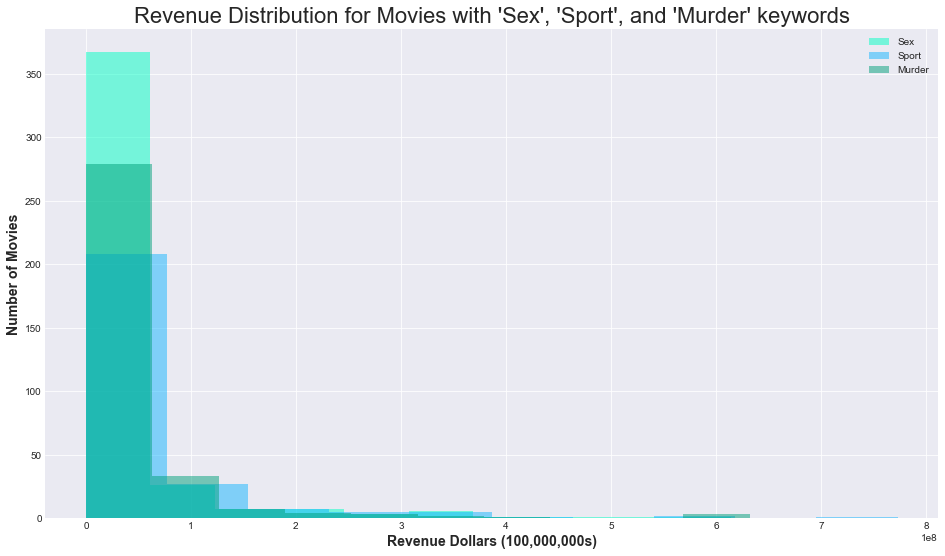

In [115]:
# Plot the three separate histograms
df_keywords[df_keywords['keywords'].str.contains('sex')]['revenue_adj'].hist(alpha = .5, label='Sex', color = hex_teal)
df_keywords[df_keywords['keywords'].str.contains('sport')]['revenue_adj'].hist(alpha = .5, label= 'Sport', color = hex_blue)
df_keywords[df_keywords['keywords'].str.contains('murder')]['revenue_adj'].hist(alpha = .5, label = 'Murder', color = hex_dgreen)

# Label the axes and edit font
plt.xlabel('Revenue Dollars (100,000,000s)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Movies', fontsize=14, fontweight ='bold')

# Set the title and title font
plt.title("Revenue Distribution for Movies with 'Sex', 'Sport', and 'Murder' keywords", fontsize=22)

# Show the legend
plt.legend();

All three keywords are similar in their revenue distributions in that they are all drastically skewed to the right. In each group, there are outliers with very high revenue dollars pulling the mean above the median.

<a id='q4'></a>
### Question 4: Is the mean revenue higher with or without each of these keywords?

Using the same groups for the data as in the previous question, we can also generate a double bar chart that illustrates the mean revenue dollars for movies with or without our three keywords.

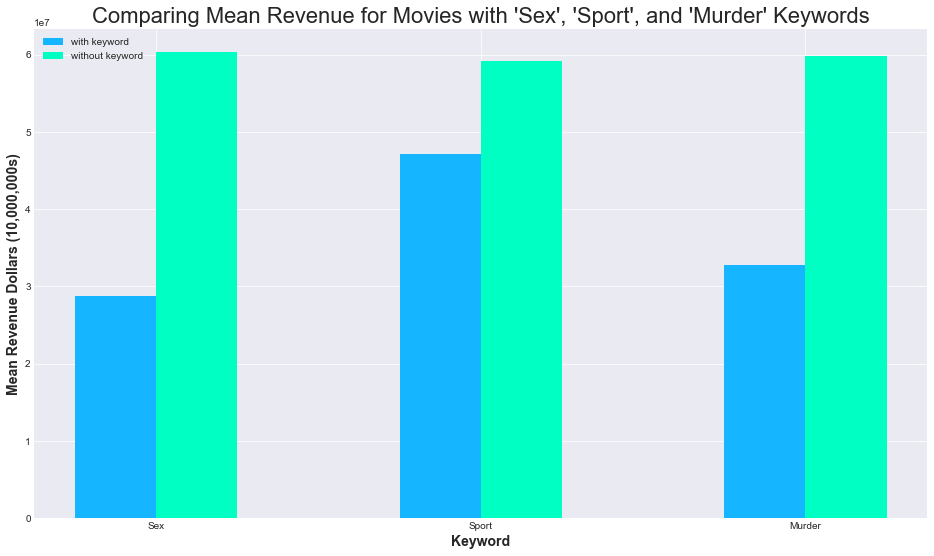

In [116]:
# Store bar labels in a list
bar_names = ['Sex', 'Sport', 'Murder']

# Store first round of heights (with keyword) in list
heights = [df_keywords[df_keywords['keywords'].str.contains('sex')]['revenue_adj'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('sport')]['revenue_adj'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('murder')]['revenue_adj'].mean()]

# Plot the bars with keywords
plt.bar(x = [1,2,3], tick_label = bar_names, height=heights, color=hex_blue, width=.25, label='with keyword')

# Store second round of heights (without keyword) in list
heights = [df_keywords[df_keywords['keywords'].str.contains('sex') == False]['revenue_adj'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('sport') == False]['revenue_adj'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('murder') == False]['revenue_adj'].mean()]

# Plot the bars with keywords
plt.bar(x = [1.25,2.25,3.25], tick_label = bar_names, height=heights, color=hex_teal, width=.25, label='without keyword')

# Set x-tick locations
plt.gca().set_xticks([1.125, 2.125, 3.125])

# Set axis labels' text and font 
plt.xlabel('Keyword', fontsize = 14, fontweight = 'bold')
plt.ylabel('Mean Revenue Dollars (10,000,000s)', fontsize = 14, fontweight = 'bold')

# Show a legend on figure
plt.legend()

# Name the barchart
plt.title("Comparing Mean Revenue for Movies with 'Sex', 'Sport', and 'Murder' Keywords", fontsize = 22);

For all three of our keywords, the mean revenue dollars appear to be higher when the keyword is not present. The mean for the keyword "Sport" is quite a bit closer to its opposite, though there is still a distinct difference between the two. This is an interesting result considering these our the most popular keywords in the dataset. Maybe they have a positive correlation to a different dependent variable.

<a id='q5'></a>
### Question 5: Is the mean user rating higher with or without each of these keywords?

Due to the similarity between Question 4 and Question 5, much of the code for creating a double bar chart can be reused to visualize the relationship between our keywords and mean user rating. 

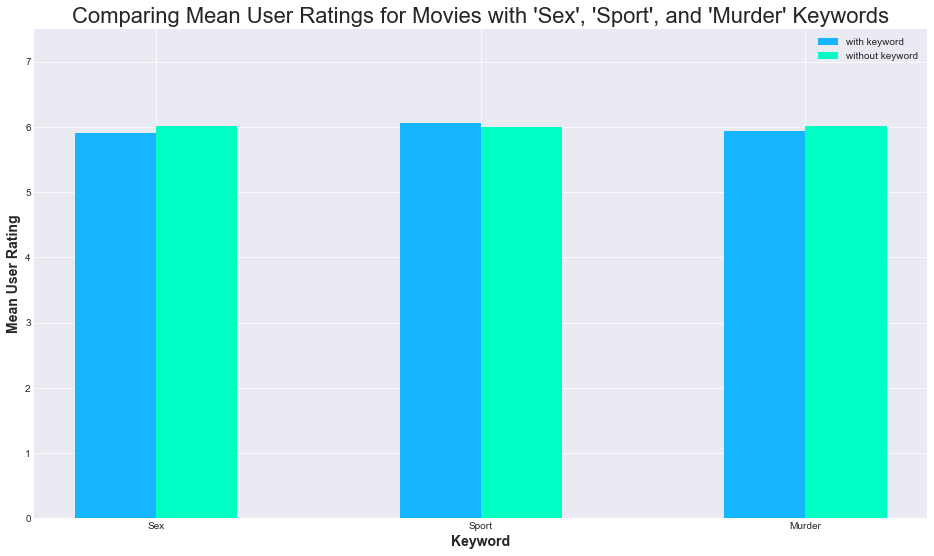

In [117]:
# Store first round of heights (with keyword) in list
heights = [df_keywords[df_keywords['keywords'].str.contains('sex')]['vote_average'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('sport')]['vote_average'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('murder')]['vote_average'].mean()]

# Plot the bars with keywords
plt.bar(x = [1,2,3], tick_label = bar_names, height=heights, color=hex_blue, width=.25, label='with keyword')

# Store second round of heights (without keyword) in list
heights = [df_keywords[df_keywords['keywords'].str.contains('sex') == False]['vote_average'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('sport') == False]['vote_average'].mean(),
           df_keywords[df_keywords['keywords'].str.contains('murder') == False]['vote_average'].mean()]

# Plot the bars with keywords
plt.bar(x = [1.25,2.25,3.25], tick_label = bar_names, height=heights, color=hex_teal, width=.25, label='without keyword')

# Set x-tick locations
plt.gca().set_xticks([1.125, 2.125, 3.125])

# Set axis labels' text and font 
plt.xlabel('Keyword', fontsize = 14, fontweight = 'bold')
plt.ylabel('Mean User Rating', fontsize = 14, fontweight = 'bold')

# Adjust the y axis max to make a bit of room for the legend
plt.ylim(ymax= 7.5)

# Show a legend on figure
plt.legend()

# Name the barchart
plt.title("Comparing Mean User Ratings for Movies with 'Sex', 'Sport', and 'Murder' Keywords", fontsize = 22);

This suggests that there isn't a correlation between the presence of any of these keywords and a higher or lower mean user rating. 

<a id='conclusions'></a>
## Conclusions

In this project, we analyzed trends in gross profit margin over time, keyword popularity, the relationship between certain keywords and revenue, and the relationship between those same keywords and user ratings. Gross profit margin does not appear to be directly correlated to time, as it seems to ebb and flow. It is likely that independent variables not considered in the present analysis are significantly impacting the profitability of the movie industry. The most popular keywords in our dataset were "woman director", "independent film", and "based on novel", though the first two were significantly more popular than the third. For the keywords "sex", "sport", and "murder", the mean revenue was much higher in the absence of the keyword than in its presence. This trend did not carry over to the keywords' effect on mean user rating, as the mean user rating was about the same with or without each of the three keywords.

All observations were made using descriptive statistical analysis; no inferential statistics were calculated. This is a weakness of the project, as this dataset may contain insights into what features could increase the chance of creating a profitable movie. 